# Classification of earthquake data into tsunami events

## Table of Contents
* [Initialization](#ini-header)
    * [Import libraries](#import-libraries-header)
    * [Load the data](#load-data-header)
* [Exploratory Data Analysis (EDA)](#eda-header)
    * [Basic information](#basic-info-header)
    * [Univariate analysis](#uni-analysis-header)
    * [Multivariate analysis](#multi-analysis-header)
* [Feature Engineering](#feature-engineering-header)
    * [Lon-Lat feature cross bucketing](#lon-lat-header)
    * [Split data into train-test sets](#prepare-data-header)
    * [Transform columns at once via pipeline](#transform-columns-pipeline-header)
* [Deep Learning Model](#dl-models-header)
    * [Set the model](#set-model-header)
    * [Train the model](#train-model-header)
* [Evaluate the model](#evaluation-header)
    * [Check the basic metrics](#basic-metrics-header)
    * [Decision threshold calibration](#thresh-cal-header)
    * [Reevalation after threshold calibration](#reevaluation-header)

## Initialization <a class="anchor" id="ini-header"></a>

### Import libraries <a class="anchor" id="import-libraries-header"></a>

In [1]:
import h5py
import pickle
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from shapely.geometry import Point
import cartopy.crs as ccrs
import utils.matplotlib_config
from utils.fun_earthquake_animation import *

import warnings
warnings.filterwarnings("ignore")

# Set random seed
np.random.seed(42)

# Get the palette
palette = plt.rcParams['axes.prop_cycle'].by_key()['color']
purple_PCM = palette[0]
golden_PCM = palette[1]

### Load the data <a class="anchor" id="load-data-header"></a>

In [2]:
# Create the Pandas DataFrame
df = pd.read_csv('data/earthquakes.csv', header=0)
df['date'] = pd.to_datetime(df['date'], format='mixed')
df.head()

,ID,lon,lat,hf,date,L,W,slip,Mo,Mw,dip,strike,rake,tsunami
0,us6000m05c,149.0388,44.5960,35.5,2023-12-28 09:15:16.131000+00:00,21627.185237,13489.628826,0.770085,6.740000e+18,6.5,25.75,241.73,122.41,0
1,us7000lkxb,27.9516,-52.0879,13.5,2023-12-22 17:36:32.014000+00:00,16368.165214,7816.278046,0.515874,1.980000e+18,6.1,85.12,203.41,173.11,0
2,usd0010b4f,184.6687,51.2097,21.5,2023-12-21 14:55:56.291000+00:00,12793.813042,8830.799004,0.601879,2.040000e+18,6.1,23.07,249.05,102.53,0
3,us7000li15,184.3459,-18.8139,270.5,2023-12-11 06:33:32.480000+00:00,20606.299133,10764.652136,0.341118,2.270000e+18,6.2,77.98,21.40,-98.72,0
4,us7000lgwp,169.3089,-20.6152,50.5,2023-12-07 12:56:30.184000+00:00,47533.522594,25468.302526,1.318907,4.790000e+19,7.1,41.80,334.28,88.61,0


In [3]:
# Scale the longitude values in the range [-180, 180]
df['lon'] = df['lon'].apply(lambda x: x if x <= 180 else x - 360)

## Exploratory Data Analysis (EDA) <a class="anchor" id="eda-header"></a>

Basic information <a class="anchor" id="basic-info-header"></a>

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5380 entries, 0 to 5379
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype              
---  ------   --------------  -----              
 0   ID       5380 non-null   object             
 1   lon      5380 non-null   float64            
 2   lat      5380 non-null   float64            
 3   hf       5380 non-null   float64            
 4   date     5380 non-null   datetime64[ns, UTC]
 5   L        5380 non-null   float64            
 6   W        5380 non-null   float64            
 7   slip     5379 non-null   float64            
 8   Mo       5379 non-null   float64            
 9   Mw       5380 non-null   float64            
 10  dip      5315 non-null   float64            
 11  strike   5315 non-null   float64            
 12  rake     5315 non-null   float64            
 13  tsunami  5380 non-null   int64              
dtypes: datetime64[ns, UTC](1), float64(11), int64(1), object(1)
memory usage: 588.6+ KB


* **Lon, lat**: epicenter's coordinates.
* **Focal depth**: depth within the Earth's crust where an earthquake's seismic energy originates.
* **L**: length of the fault plane.
* **W**: width of the fault plane.
* **Strike direction**: compass direction of a horizontal line on a tilted geological feature, such as a fault or rock layer.
* **Dip angle**: angle of the steepest descent or incline of a geological feature, such as a fault or rock layer, measured perpendicular to the strike direction.
* **Rake/Slip angle**: angle between the orientation of a fault plane and the direction of movement along that fault during an earthquake.
* **Dislocation (slip)**: movement of rocks along a fault line during an earthquake, causing the release of stored energy.
* **M0**: scalar seismic moment.
* **Mw**: earthquake's magnitude.
* **Z** : average depth on the fault zone.

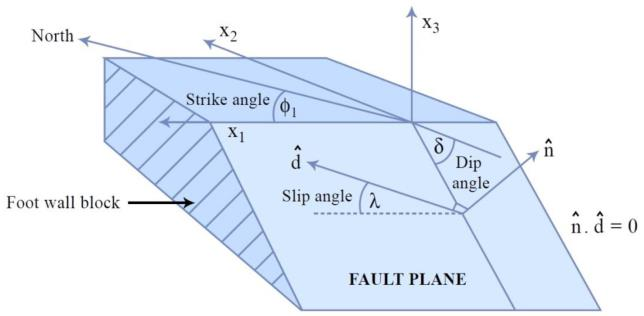

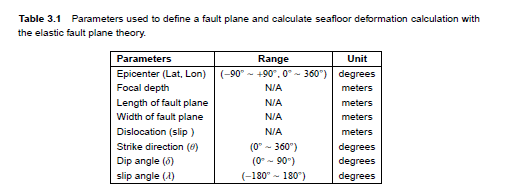

In [5]:
# Check nan values
df.isnull().sum()

ID          0
lon         0
lat         0
hf          0
date        0
L           0
W           0
slip        1
Mo          1
Mw          0
dip        65
strike     65
rake       65
tsunami     0
dtype: int64

In [6]:
# Drop nan values
df = df.dropna().reset_index(drop=True)

### Univariate analysis <a class="anchor" id="uni-analysis-header"></a>

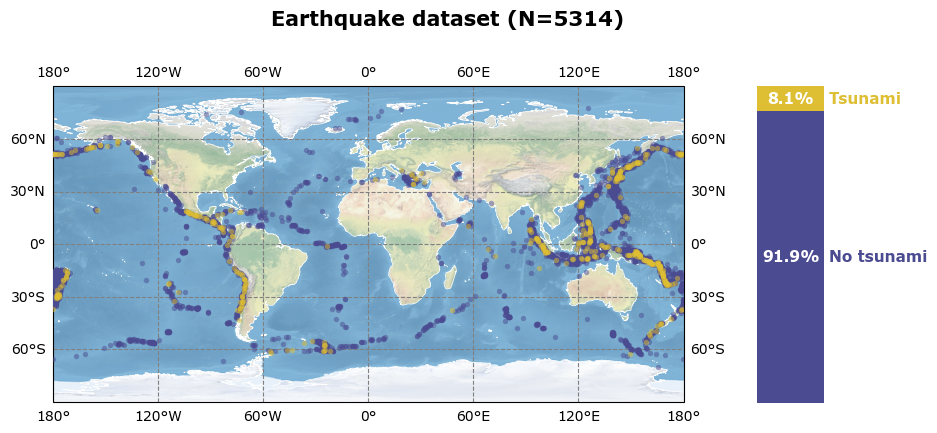

In [7]:
# Create a GeoDataFrame
gdf = df.copy()
geometry = [Point(lon, lat) for lon, lat in zip(gdf['lon'], gdf['lat'])]
gdf = gpd.GeoDataFrame(gdf, geometry=geometry)

# Set a CRS
gdf.set_crs(epsg=4326, inplace=True)

# Create the matplotlib figure and axis
fig, (ax_map, ax_bar) = plt.subplots(1, 2, figsize=(10, 10),
                                     gridspec_kw={'width_ratios': [3, 0.35]},
                                     subplot_kw={'projection': ccrs.PlateCarree() if 'ax_map' else None})

# Map settings
ax_map.stock_img()
ax_map.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax_map.coastlines(resolution='50m', linewidth=.5, color="white")
ax_map.gridlines(draw_labels=True)

# Plot the events
gdf[gdf['tsunami'] == 0].plot(ax=ax_map, marker='o', color=purple_PCM,
                              markersize=15, transform=ccrs.PlateCarree(),
                              label='No tsunami', zorder=20, alpha=0.5, lw=0)
gdf[gdf['tsunami'] == 1].plot(ax=ax_map, marker='o', color=golden_PCM,
                              markersize=15, transform=ccrs.PlateCarree(),
                              label='Tsunami', zorder=20, alpha=0.5, lw=0)
#ax_map.legend()

# Plot a stacked bar plot
df_count = gdf['tsunami'].value_counts(normalize=True).rename(index={0: 'No tsunami', 1: 'Tsunami'}).to_frame()
ax_bar.bar(0, df_count.loc["No tsunami"], color=purple_PCM, label='No tsunami', width=0.211)
ax_bar.bar(0, df_count.loc["Tsunami"], bottom=df_count.loc["No tsunami"], color=golden_PCM, label='Tsunami', width=0.211)
# Add annotations to the bar plot at the middle of each bar
for i, (index, row) in enumerate(df_count.iterrows()):
    ax_bar.text(0, row[0] / 2 + df_count.iloc[:i].sum()[0], f'{row[0]:.1%}',
                ha='center', va='center', color='white', weight='bold', fontsize=11)
    # Add the label to the right of the bar plot at the same y position
    ax_bar.text(0.12, row[0] / 2 + df_count.iloc[:i].sum()[0], index,
                ha='left', va='center', color=purple_PCM if i == 0 else golden_PCM, weight='bold', fontsize=11)
ax_bar.set_ylim(0, 1)
ax_bar.axis('off')

fig.suptitle(f'Earthquake dataset (N={len(gdf)})',
             fontsize=15, weight='bold', y=0.73, x=0.52)
fig.savefig('images/events_map.png', dpi=600, bbox_inches='tight', transparent=True)

In [8]:
# Call the function to create the animation
#create_earthquake_animation(gdf)

In [9]:
print('Count of tsunamis')
df['tsunami'].value_counts().rename(index={0:'No tsunami', 1:'Tsunami'})

Count of tsunamis


tsunami
No tsunami    4881
Tsunami        433
Name: count, dtype: int64

In [10]:
print('Which in frequency terms means')
df['tsunami'].value_counts().apply(lambda x: '%.2f%%' % (x / len(df) * 100)).rename(index={0: 'No tsunami',
                                                                                           1: 'Tsunami'})

Which in frequency terms means


tsunami
No tsunami    91.85%
Tsunami        8.15%
Name: count, dtype: object

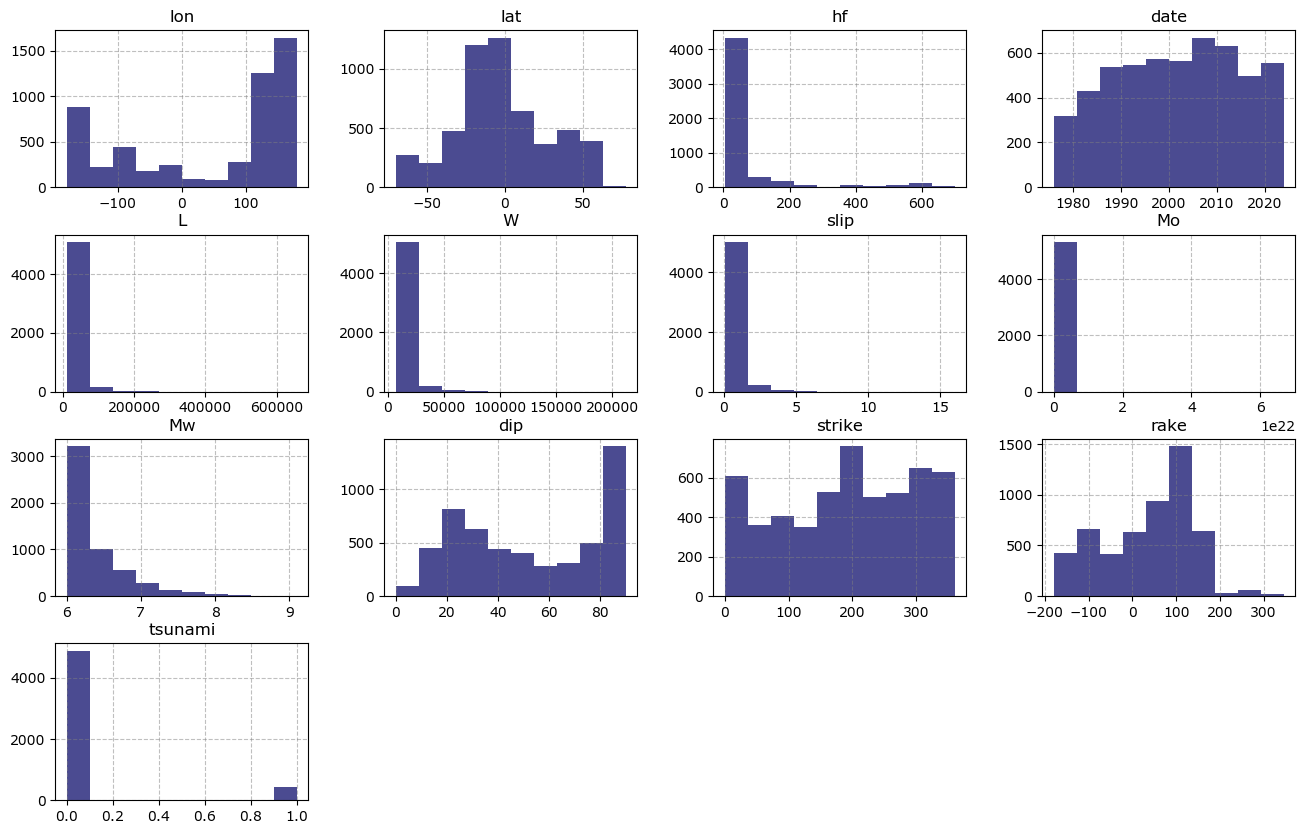

In [11]:
df.hist(figsize=(16, 10));

### Multivariate analysis <a class="anchor" id="multi-analysis-header"></a>

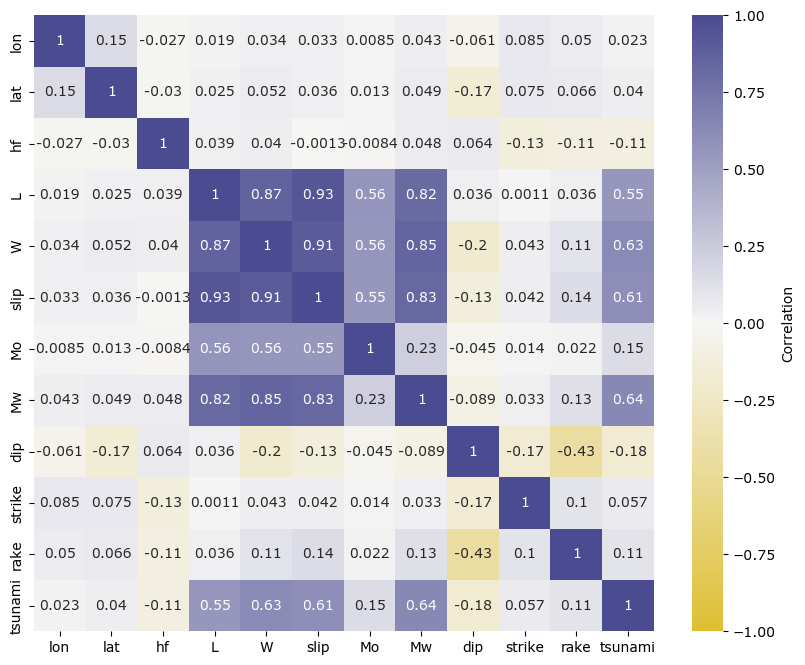

In [12]:
df_corr = df.select_dtypes(include='number').corr(method='pearson')
# Correlation matrix between columns
plt.figure(figsize=(10, 8))
sns.heatmap(df_corr,
            xticklabels=df_corr.columns,
            yticklabels=df_corr.columns,
            cmap='PCM_cmap_s', center=0, vmin=-1, annot=True,
            cbar_kws={'label': 'Correlation'})
plt.grid()

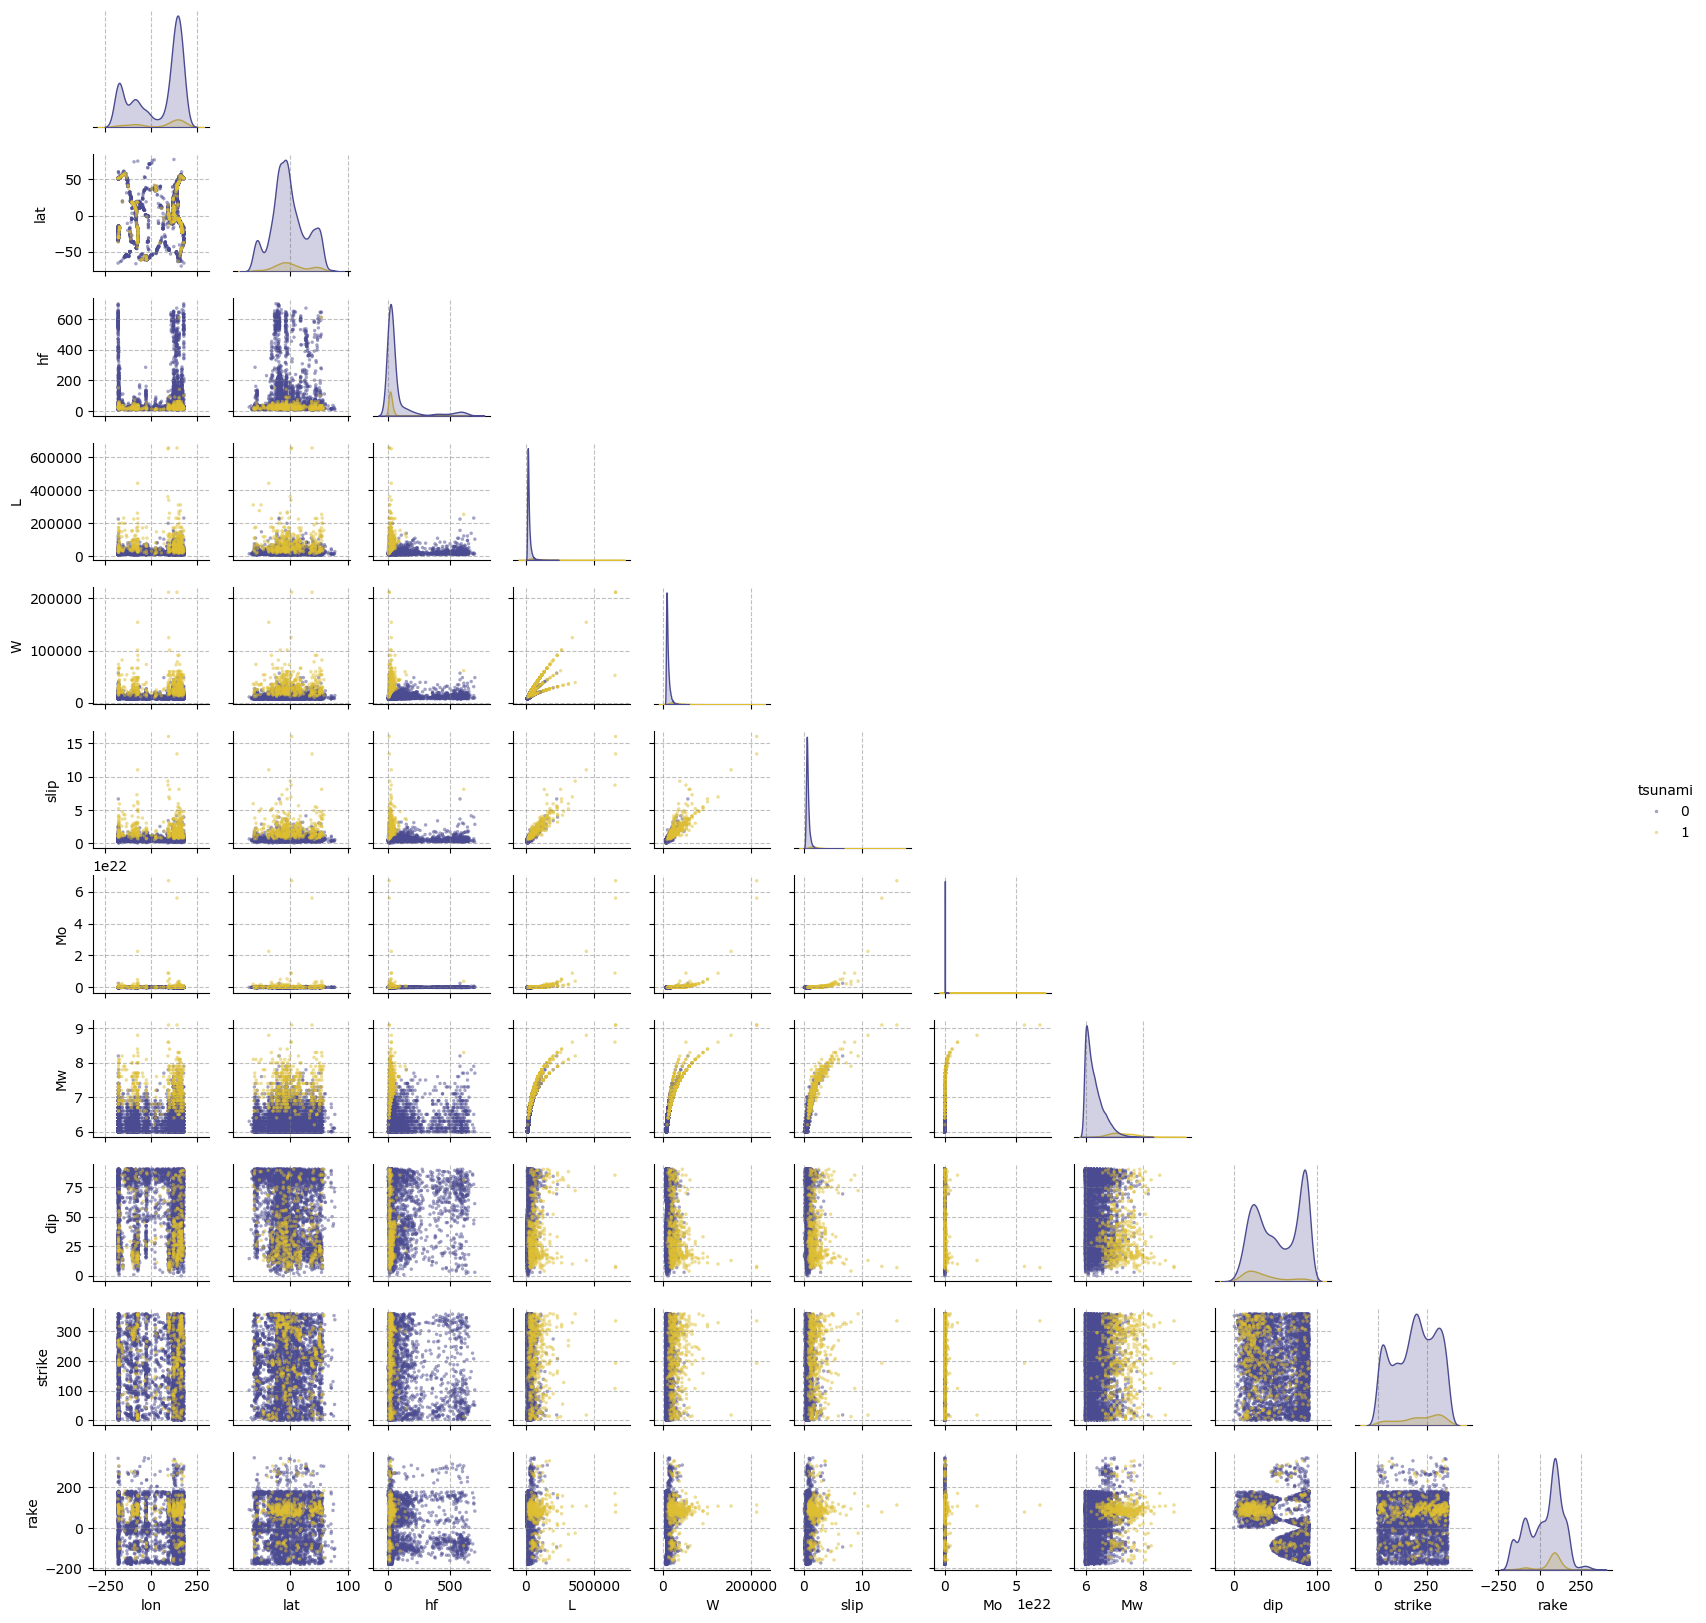

In [13]:
# Sort the dataframe based on 'tsunami' column
df_sorted = df.sort_values(by='tsunami')

# Create a pairplot
sns.pairplot(df_sorted.select_dtypes(include='number'), hue='tsunami', hue_order=[0, 1],
             corner=True, plot_kws=dict(edgecolor=None, alpha=0.5, s=5), height=1.5);

## Feature Engineering <a class="anchor" id="feature-engineering-header"></a>

### Lon-Lat feature cross bucketing <a class="anchor" id="lon-lat-header"></a>

(more info at https://developers.google.com/machine-learning/data-prep/transform/bucketing)

The main idea is to encode both longitude and latitude coordinates into one single column by using "Count Encoding" technique. In addition, the encoding technique is performed by a resampling method.

In [14]:
# Define the lon-lat grid
hist, x_edges, y_edges = np.histogram2d([-180, 180], [-90, 90], bins=30) # 30x30 grid

# Bin the coordinates
df['lon_bins'] = pd.cut(df['lon'], bins=x_edges)
df['lat_bins'] = pd.cut(df['lat'], bins=y_edges)

# Create single lon-lat category by grouping both category coordinates
df['lon_lat_categories'] = df['lon_bins'].astype(str) + '--' + df['lat_bins'].astype(str)
df['lon_lat_categories'] = df['lon_lat_categories'].astype('category')

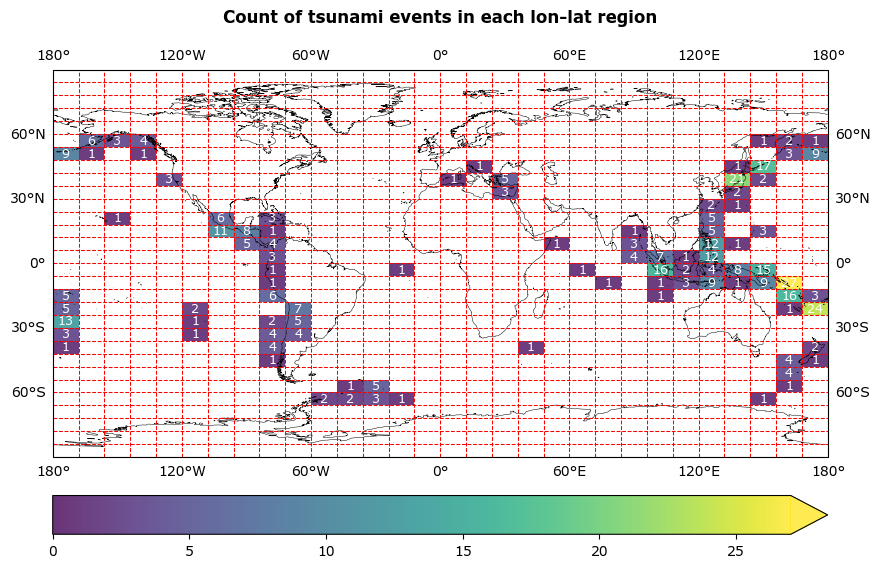

In [15]:
# Let's visualize this count on a map
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines(resolution='50m', linewidth=.35)
sns.histplot(data=df.loc[df['tsunami']==1, :], x='lon', y='lat',
             bins=(x_edges, y_edges), cbar=True, cmap='viridis', alpha=.8,
             cbar_kws={'orientation':'horizontal', 'pad':0.05, 'extend':'max'})
#sns.scatterplot(data=df, x='lon', y='lat', hue='tsunami', s=10, palette=['green', 'red'], ax=ax)
ax.vlines(x_edges, ymin=-90, ymax=90, ls='--', lw=.75, color='red')
ax.hlines(y_edges, xmin=-180, xmax=180, ls='--', lw=.75, color='red')
ax.gridlines(alpha=0, draw_labels=True)
for i in range(len(y_edges) - 1):
    for j in range(len(x_edges) - 1):
        count = ((df.loc[df['tsunami']==1,'lon'] >= x_edges[j]) & (df.loc[df['tsunami']==1,'lon'] < x_edges[j + 1]) &
                 (df.loc[df['tsunami']==1,'lat'] >= y_edges[i]) & (df.loc[df['tsunami']==1,'lat'] < y_edges[i + 1])).sum()
        if count != 0: # Only plot the text if there are events in the region
            plt.text((x_edges[j] + x_edges[j + 1]) / 2, (y_edges[i] + y_edges[i + 1]) / 2,
                 str(count), ha='center', va='center', color='white', fontsize=9)
ax.set_title('Count of tsunami events in each lon-lat region', weight='bold', y=1.1);
plt.savefig('images/lonlat_count_encoding.png', dpi=300, bbox_inches='tight')

In [16]:
def count_adjacent(df: pd.DataFrame, lon_bin: pd.Interval, lat_bin: pd.Interval, lon_step: int, lat_step: int):
    """
    Count the number of adjacent tsunami occurrences in a DataFrame based on specified longitude and latitude bins.
    Parameters:
    df (pd.DataFrame): DataFrame containing tsunami data with 'lon_bins', 'lat_bins', and 'tsunami' columns.
    lon_bin (pd.Interval): Interval representing the current longitude bin.
    lat_bin (pd.Interval): Interval representing the current latitude bin.
    lon_step (int): Step size to shift the longitude bin.
    lat_step (int): Step size to shift the latitude bin.
    Returns:
    int: The count of adjacent tsunami occurrences.
    """

    if (lon_bin.left == -180 and lon_step < 0) or (lon_bin.right == 180 and lon_step > 0):
        # Special case for longitude boundaries
        lon_stretch = (df['lon_bins'] == pd.Interval(lon_bin.right *-1, lon_bin.left *-1, closed='right'))
    else:
        lon_stretch = (df['lon_bins'] == pd.Interval(lon_bin.left - lon_step, lon_bin.right - lon_step, closed='right'))

    lat_stretch = (df['lat_bins'] == pd.Interval(lat_bin.left - lat_step, lat_bin.right - lat_step, closed='right'))

    return ((df['tsunami'] == 1) & lon_stretch & lat_stretch).sum()

def convert_string_to_bins(string_lon_lat_cat):
    """
    Convert a string representation of longitude and latitude intervals into pandas Interval objects.
    Parameters:
    string_lon_lat_cat (str): A string containing longitude and latitude intervals separated by '--'.
                              Each interval is represented as '(left_limit,right_limit)'.
    Returns:
    tuple: A tuple containing two pandas Interval objects, one for longitude and one for latitude.
    """
    # Retrieve lon and lat strings
    lon_string = string_lon_lat_cat.split('--')[0]
    lat_string = string_lon_lat_cat.split('--')[1]
    
    # Define an empty list
    lonlat_cats = []

    for coord in [lon_string, lat_string]:
        # Extract the values from the string
        coords = coord.strip('()[]').split(',')
        left_limit = float(coords[0])
        right_limit = float(coords[1])

        lonlat_cats.append(pd.Interval(left=left_limit, right=right_limit, closed='right'))

    return lonlat_cats[0], lonlat_cats[1]

In [17]:
# Define the mesh pitch
lon_step = np.diff(x_edges)[0]
lat_step = np.diff(y_edges)[0]

# Set the number of resamplings
n_resampling = 250

# Define a dictionary with two empty lists that will be filled with the countings of the actual cell and the adjacent cells
spatial_cats = {cat:[[], []] for cat in df['lon_lat_categories'].unique()}

for _ in range(n_resampling):
    # Create the sample
    df_sample = df.sample(frac=0.8)
    
    for cat in spatial_cats:
        # Set to 0 the countings
        i_actual_count, i_adjacent_count = 0, 0

        # Extract the lon and lat bins
        lon_bin, lat_bin = convert_string_to_bins(cat)

        # Add the counting for the actual cell
        i_actual_count += count_adjacent(df_sample, lon_bin, lat_bin, 0, 0)

        # Save the results of the countings in each list
        spatial_cats[cat][0].append(i_actual_count)

# Add the results in two columns by computing the mean value
df['lon_lat_count'] = df['lon_lat_categories'].apply(lambda x: np.mean(spatial_cats[x][0]))

In [18]:
# Save the lon_lat_count in a pickle file
with open('models/lon_lat_count.pkl', 'wb') as f:
    pickle.dump(df.groupby("lon_lat_categories")["lon_lat_count"].first(), f)

### Split data into train-test sets <a class="anchor" id="prepare-data-header"></a>

In [19]:
from sklearn.model_selection import train_test_split

# Define the columns to keep, that is, the features of the model
cols_to_keep = ['hf', 'L', 'W', 'slip', 'Mo', 'dip', 'strike', 'rake', 'lon_lat_count']
X = df[cols_to_keep] # Features
y = df['tsunami'] # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

### Transform columns at once via pipeline <a class="anchor" id="transform-columns-pipeline-header"></a>

In [20]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Define the pipelines
std_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

log_pipeline = Pipeline([
    ('log_scaler', FunctionTransformer(np.log)),
    ('imputer', SimpleImputer(strategy='constant', fill_value=0))
    ])

def process_rake(x):
    return abs(90 - x)

rake_pipeline = Pipeline([
    ('process_rake', FunctionTransformer(process_rake)),
    ('minmax_scaler', MinMaxScaler())
    ])

# Define the columns with the respective function to be applied
cols_convert_to_radians = ['dip', 'strike']
cols_std_scaler = ['slip']
cols_minmax_scaler = ['lon_lat_count']
cols_log_pipeline = ['Mo', 'hf', 'W', 'L']

# Define the full pipeline with all functions
full_pipeline = ColumnTransformer(
    transformers=[
        ("convert_to_radians", FunctionTransformer(np.deg2rad), cols_convert_to_radians),
        ("rake_process", rake_pipeline, ['rake']),
        ("std_scaler", std_scaler, cols_std_scaler),
        ("minmax_scaler", minmax_scaler, cols_minmax_scaler),
        ("log_pipeline", log_pipeline, cols_log_pipeline)
        ],
        remainder='passthrough',
        verbose_feature_names_out=False).set_output(transform='pandas')

# Apply the pipeline
X_train = full_pipeline.fit_transform(X_train).reindex(columns=X.columns)
X_test = full_pipeline.transform(X_test).reindex(columns=X.columns)

In [21]:
# Save the pipeline object
with open('models/preprocessor.pkl', 'wb') as f:
    pickle.dump(full_pipeline, f)

## Deep Learning Model <a class="anchor" id="dl-models-header"></a>

### Set the model <a class="anchor" id="set-model-header"></a>

In [22]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import backend as K

tf.keras.backend.clear_session()
tf.keras.utils.set_random_seed(42)

# Define the score metric (that is, Fbeta score)
def fbeta(y_true, y_pred, beta=2):
    y_pred = K.clip(y_pred, 0, 1)

    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=1)
    fp = K.sum(K.round(K.clip(y_pred - y_true, 0, 1)), axis=1)
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)), axis=1)

    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    fbeta_score = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall + K.epsilon())

    return K.mean(fbeta_score)

In [23]:
# Get the input dimension
input_dim = X_train.shape[1]

# Create the ANN model
model = Sequential()
model.add(Dense(128, input_dim=input_dim, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [24]:
# Compile the model
model.compile(loss='binary_focal_crossentropy', optimizer='adam', metrics=[fbeta])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1280      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 16)                5

### Train the model <a class="anchor" id="train-model-header"></a>

In [25]:
# Fit the model
history = model.fit(X_train, y_train, epochs=5000,
                    batch_size=64, validation_split=0.2, verbose=0)

(Text(0.5, 0, 'Epochs'), Text(0, 0.5, 'Fβ score'))

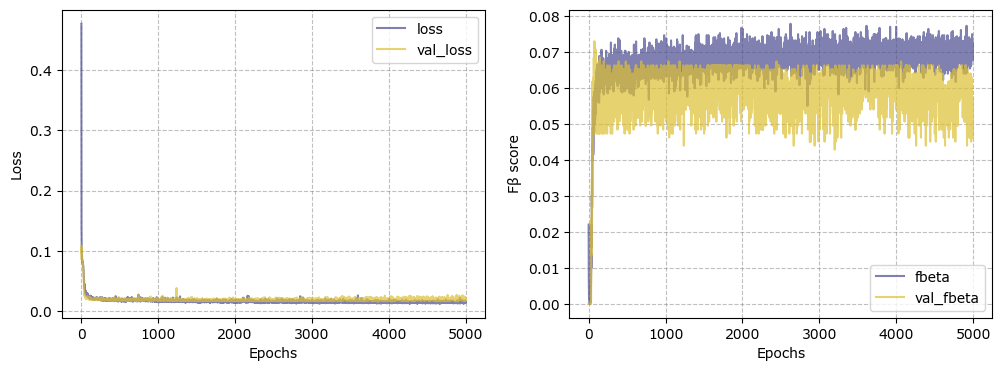

In [26]:
# Show the loss and fbeta of the model
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
pd.DataFrame(history.history)[['loss','val_loss']].plot(ax=ax[0], alpha=0.7)
ax[0].set_xlabel("Epochs"), ax[0].set_ylabel("Loss")
pd.DataFrame(history.history)[['fbeta','val_fbeta']].plot(ax=ax[1], alpha=0.7)
ax[1].set_xlabel("Epochs"), ax[1].set_ylabel("Fβ score")

In [27]:
# Save the model trained with its fine-tuned hyperparameters
filename = 'DenseANN.h5'
model.save('models/' + filename)

## Evaluate the model <a class="anchor" id="evaluation-header"></a>

### Check the basic metrics <a class="anchor" id="basic-metrics-header"></a>

In [28]:
def adjusted_classes(y_scores, t=None):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    """
    if t is None:
        t = 0.5 # default threshold
    return np.array([1 if y >= t else 0 for y in y_scores])

Confusion matrices

133/133 [==============================] - 0s 810us/step


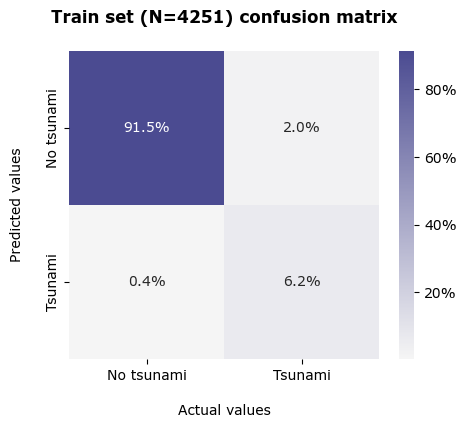

In [29]:
from sklearn.metrics import confusion_matrix

# Predict the train set
y_train_pred = adjusted_classes(model.predict(X_train)[:, 0])

# Generate the confusion matrix
cf_matrix = confusion_matrix(y_train_pred, y_train)

plt.figure(figsize=(5, 4))
ax = sns.heatmap(cf_matrix / np.sum(cf_matrix),
                 annot=True, cmap='PCM_Purple_r', fmt='.1%')
ax.set_title('Train set (N=%.f) confusion matrix\n' % X_train.shape[0],
             fontsize=12, weight='bold')
ax.set_xlabel('\nActual values', fontsize=10)
ax.set_ylabel('Predicted values\n', fontsize=10)

# Tick labels
ax.xaxis.set_ticklabels(['No tsunami', 'Tsunami'])
ax.yaxis.set_ticklabels(['No tsunami', 'Tsunami'], va='center')

# Colorbar label ticks
colorbar = ax.collections[0].colorbar
ticks = colorbar.ax.get_yticks()
ticks = [str(int(tick*100)) + '%' for tick in ticks]
colorbar.set_ticklabels(ticks)

plt.grid()

34/34 [==============================] - 0s 825us/step


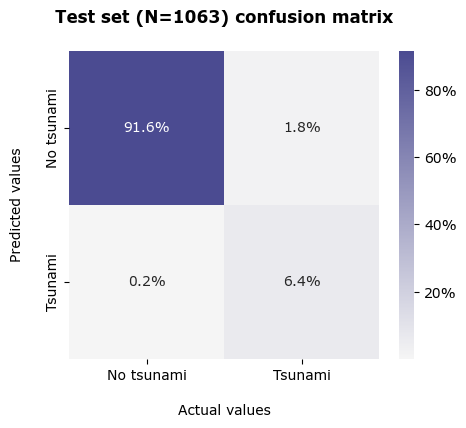

In [30]:
# Predict the test set
y_test_pred = adjusted_classes(model.predict(X_test)[:, 0])

# Generate the confusion matrix
cf_matrix = confusion_matrix(y_test_pred, y_test)

plt.figure(figsize=(5, 4))
ax = sns.heatmap(cf_matrix / np.sum(cf_matrix),
                 annot=True, cmap='PCM_Purple_r', fmt='.1%')
ax.set_title('Test set (N=%.f) confusion matrix\n' % X_test.shape[0],
             fontsize=12, weight='bold')
ax.set_xlabel('\nActual values', fontsize=10)
ax.set_ylabel('Predicted values\n', fontsize=10)

# Tick labels
ax.xaxis.set_ticklabels(['No tsunami', 'Tsunami'])
ax.yaxis.set_ticklabels(['No tsunami', 'Tsunami'], va='center')

# Colorbar label ticks
colorbar = ax.collections[0].colorbar
ticks = colorbar.ax.get_yticks()
ticks = [str(int(tick*100))+'%' for tick in ticks]
colorbar.set_ticklabels(ticks)

plt.grid()

ROC Curve

Text(0.5, 1.0, 'ROC Curve')

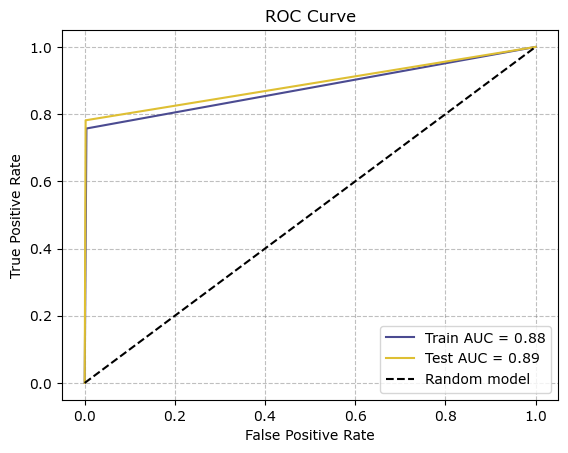

In [31]:
from sklearn import metrics

# Train metrics
train_fpr, train_tpr, _ = metrics.roc_curve(y_train,  y_train_pred)
train_auc = metrics.roc_auc_score(y_train,  y_train_pred)

# Test metrics
test_fpr, test_tpr, _ = metrics.roc_curve(y_test,  y_test_pred)
test_auc = metrics.roc_auc_score(y_test, y_test_pred)

fig, ax = plt.subplots()
ax.plot(train_fpr, train_tpr, label='Train AUC = %.2f' % (train_auc))
ax.plot(test_fpr, test_tpr, label='Test AUC = %.2f' % (test_auc))
ax.plot(test_fpr, test_fpr, ls='--', color='k', label='Random model')
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')
ax.legend(loc='lower right')
ax.set_title('ROC Curve')

Classification metrics

In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score

print('Accuracy:')
print("Train: %.2f" % accuracy_score(y_train, y_train_pred))
print("Test: %.2f" % accuracy_score(y_test, y_test_pred))

print('\nPrecision (tp / (tp + fp)):')
print("Train: %.2f" % precision_score(y_train, y_train_pred))
print("Test: %.2f" % precision_score(y_test, y_test_pred))

print('\nRecall (tp / (tp + fn)):')
print("Train: %.2f" % recall_score(y_train, y_train_pred))
print("Test: %.2f" % recall_score(y_test, y_test_pred))

print('\nF1-Score (2 * (precision * recall) / (precision + recall)):')
print("Train: %.2f" % f1_score(y_train, y_train_pred))
print("Test: %.2f" % f1_score(y_test, y_test_pred))

print('\nFβ-Score (β=2):')
print("Train: %.2f" % fbeta_score(y_train, y_train_pred, beta=2))
print("Test: %.2f" % fbeta_score(y_test, y_test_pred, beta=2))


Accuracy:
Train: 0.98
Test: 0.98

Precision (tp / (tp + fp)):
Train: 0.95
Test: 0.97

Recall (tp / (tp + fn)):
Train: 0.76
Test: 0.78

F1-Score (2 * (precision * recall) / (precision + recall)):
Train: 0.84
Test: 0.87

Fβ-Score (β=2):
Train: 0.79
Test: 0.81


### Decision threshold calibration <a class="anchor" id="thresh-cal-header"></a>

Threshold calibration in a binary classification problem with imbalanced data serves a pivotal role. When dealing with a scenario where one class is significantly more frequent than the other, adjusting the decision threshold becomes essential to enhance model performance.  To do this, a Precision-Recall Curve will be plotted and the best threshold will be computed by maximizing Fbeta-score metric. Fbeta-score is similar to the F1-score but puts more weight on recall than precision, since in this problem FN have more importance than FP.

$Fbeta = ((1 + β ^ 2) * P * R) / (β ^ 2 * P + R)$

where β > 1

34/34 [==============================] - 0s 819us/step


Text(0.5, 1.0, 'Precision-Recall Curve')

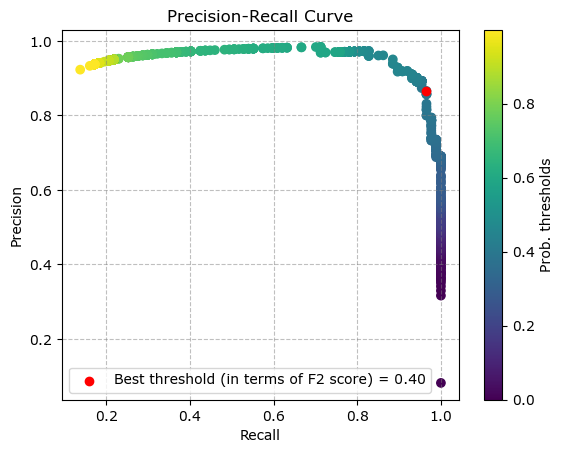

In [33]:
# Find the optimal threshold for binary classification
beta = 2
thresholds = np.arange(0, 1, 0.001) # Define the thresholds
precision_t, recall_t, fbetascore_t = [], [], []

# Get the predicted probabilities for positive class
y_pred_prob = model.predict(X_test)[:, 0]

# Compute the precision, recall and Fbeta score for each threshold
for t in thresholds:
    y_pred_t = adjusted_classes(y_pred_prob, t)
    precision_t.append(precision_score(y_test, y_pred_t))
    recall_t.append(recall_score(y_test, y_pred_t))
    fbetascore_t.append(fbeta_score(y_test, y_pred_t, beta=beta))

# Find the best threshold in terms of Fbeta score
best_thresh = thresholds[np.nanargmax(fbetascore_t)]

fig, ax = plt.subplots()
test_scatter = ax.scatter(recall_t, precision_t, c=thresholds, marker='o')
cbar = plt.colorbar(test_scatter)
cbar.set_label('Prob. thresholds')
ax.scatter(recall_t[np.nanargmax(fbetascore_t)],
           precision_t[np.nanargmax(fbetascore_t)],
           marker='o', color='red', label='Best threshold (in terms of F%.0f score) = %.2f' % (beta, best_thresh), zorder=2)
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.legend(loc='best')
ax.set_title('Precision-Recall Curve')

### Reevaluation after threshold calibration <a class="anchor" id="reevaluation-header"></a>

In [34]:
# Re-evaluate the model with the best threshold
y_train_pred = adjusted_classes(model.predict(X_train)[:, 0], best_thresh)
y_test_pred = adjusted_classes(model.predict(X_test)[:, 0], best_thresh)

34/34 [==============================] - 0s 818us/step


Confusion matrices

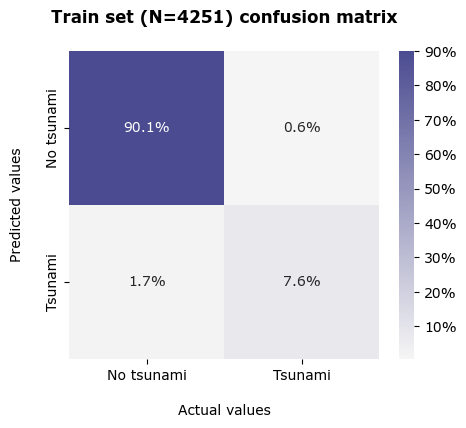

In [35]:
# Generate the confusion matrix
cf_matrix = confusion_matrix(y_train_pred, y_train)

plt.figure(figsize=(5, 4))
ax = sns.heatmap(cf_matrix / np.sum(cf_matrix),
                 annot=True, cmap='PCM_Purple_r', fmt='.1%')
ax.set_title('Train set (N=%.f) confusion matrix\n' % X_train.shape[0],
             fontsize=12, weight='bold')
ax.set_xlabel('\nActual values', fontsize=10)
ax.set_ylabel('Predicted values\n', fontsize=10)

# Tick labels
ax.xaxis.set_ticklabels(['No tsunami', 'Tsunami'])
ax.yaxis.set_ticklabels(['No tsunami', 'Tsunami'], va='center')

# Colorbar label ticks
colorbar = ax.collections[0].colorbar
ticks = colorbar.ax.get_yticks()
ticks = [str(int(tick * 100)) + '%' for tick in ticks]
colorbar.set_ticklabels(ticks)

# Display the visualization of the Confusion Matrix
plt.grid()
plt.savefig('images/train_confusion_matrix.png', dpi=600, bbox_inches='tight', transparent=True)

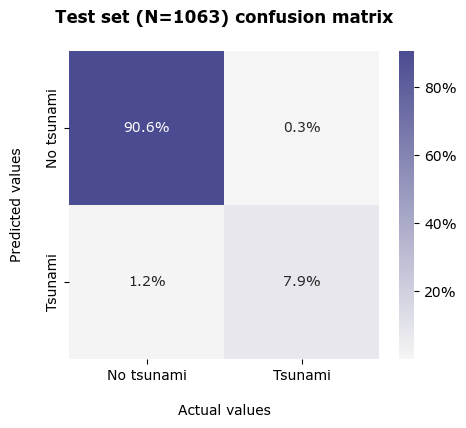

In [36]:
# Generate the confusion matrix
cf_matrix = confusion_matrix(y_test_pred, y_test)

plt.figure(figsize=(5, 4))
ax = sns.heatmap(cf_matrix / np.sum(cf_matrix),
                 annot=True, cmap='PCM_Purple_r', fmt='.1%')
ax.set_title('Test set (N=%.f) confusion matrix\n' % X_test.shape[0],
             fontsize=12, weight='bold')
ax.set_xlabel('\nActual values', fontsize=10)
ax.set_ylabel('Predicted values\n', fontsize=10)

# Tick labels
ax.xaxis.set_ticklabels(['No tsunami', 'Tsunami'])
ax.yaxis.set_ticklabels(['No tsunami', 'Tsunami'], va='center')

# Colorbar label ticks
colorbar = ax.collections[0].colorbar
ticks = colorbar.ax.get_yticks()
ticks = [str(int(tick * 100)) + '%' for tick in ticks]
colorbar.set_ticklabels(ticks)

# Display the visualization of the Confusion Matrix
plt.grid()
plt.savefig('images/test_confusion_matrix.png', dpi=600, bbox_inches='tight', transparent=True)

Classification metrics

In [37]:
# Print the metrics with the new threshold
print('Accuracy:')
print("Train: %.2f" % accuracy_score(y_train, y_train_pred))
print("Test: %.2f" % accuracy_score(y_test, y_test_pred))

print('\nPrecision (tp / (tp + fp)):')
print("Train: %.2f" % precision_score(y_train, y_train_pred))
print("Test: %.2f" % precision_score(y_test, y_test_pred))

print('\nRecall (tp / (tp + fn)):')
print("Train: %.2f" % recall_score(y_train, y_train_pred))
print("Test: %.2f" % recall_score(y_test, y_test_pred))

print('\nF1-Score (2 * (precision * recall) / (precision + recall)):')
print("Train: %.2f" % f1_score(y_train, y_train_pred))
print("Test: %.2f" % f1_score(y_test, y_test_pred))

print('\nFβ-Score (β=2):')
print("Train: %.2f" % fbeta_score(y_train, y_train_pred, beta=2))
print("Test: %.2f" % fbeta_score(y_test, y_test_pred, beta=2))

Accuracy:
Train: 0.98
Test: 0.98

Precision (tp / (tp + fp)):
Train: 0.81
Test: 0.87

Recall (tp / (tp + fn)):
Train: 0.93
Test: 0.97

F1-Score (2 * (precision * recall) / (precision + recall)):
Train: 0.87
Test: 0.91

Fβ-Score (β=2):
Train: 0.90
Test: 0.94


Evaluate the prediction probabilities <a class="anchor" id="pred-prob-header"></a>

In [38]:
# Compute the probability of the positive class for the train and test sets
# Train set
y_train_prob_df = y_train[y_train == 1].to_frame()
y_train_prob_df["Set"] = "Train"
y_train_prob_df["Model Probability"] = model.predict(X_train)[:, 0][y_train == 1]
# Test set
y_test_prob_df = y_test[y_test == 1].to_frame()
y_test_prob_df["Set"] = "Test"
y_test_prob_df["Model Probability"] = model.predict(X_test)[:, 0][y_test == 1]
# Concatenate the two DataFrames
y_prob_df = pd.concat([y_train_prob_df, y_test_prob_df])

34/34 [==============================] - 0s 819us/step


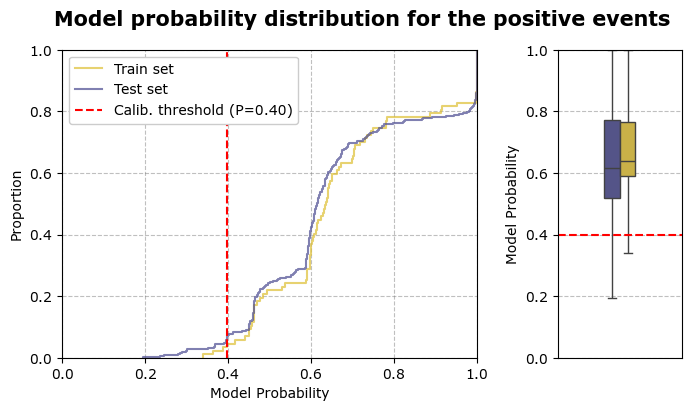

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), width_ratios=[1, 0.3])
# ECDF plot
sns.ecdfplot(data=y_prob_df, x="Model Probability",
             hue="Set",
             alpha=0.7, ax=ax[0])
ax[0].axvline(best_thresh, color='r', ls='--')
ax[0].legend(['Train set', 'Test set', f'Calib. threshold (P={best_thresh:.2f})'], loc='upper left', framealpha=1)
ax[0].set_xlim(0, 1)
# Boxplot
sns.boxplot(data=y_prob_df, y="Model Probability", 
            hue="Set", width=0.25, ax=ax[1])
ax[1].axhline(best_thresh, color='r', ls='--')
# Remove the x tick
ax[1].set_xticks([])
ax[1].set_ylim(0, 1)
# Remove the legend
ax[1].get_legend().remove()
# Add space between the subplots
plt.subplots_adjust(wspace=0.3)
fig.suptitle('Model probability distribution for the positive events', fontsize=15, weight='bold')
fig.savefig('images/model_probability_distribution.png', dpi=600, bbox_inches='tight')